In [2]:
import numpy as np

import pandas as pd

import xarray as xr

import glob

import matplotlib as mpl

import matplotlib.pyplot as plt

import math as mt

from math import e

import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from random import seed
from random import randint

from scipy.signal import hilbert
import statistics
from scipy.stats import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Read IPSL files

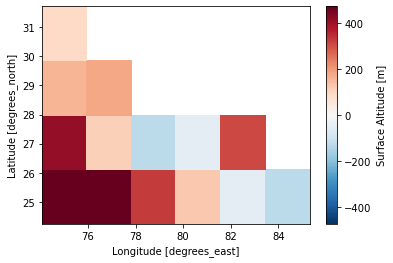

In [3]:
#Read Orography
I_OroData = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/orog_fx_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn.nc')
Ioro=I_OroData.orog.sel(lat=slice(24,32),lon=slice(74,86))
#Ioro.plot()
#Create Mask
Ioro.values[Ioro.values>500.1]=np.NaN
Imask=Ioro.values/Ioro.values
Ioro.plot()

# GFDL T2m and T2m hilbert

In [4]:
#Read Data
I_t2mData= xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/tas_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#time1=I_t2mData.indexes['time'].to_datetimeindex()
#I_t2mData=I_t2mData.assign_coords(time=("time", time1))
It2mD = I_t2mData.sel(lat=slice(24,32),lon=slice(74,86))

In [5]:

#Mask data
It2mD.tas.values=It2mD.tas.values*Imask
# area avg
It2mTS=It2mD.mean(dim=['lat','lon'], skipna=True).tas
#Hilbert transform
It2m_hb = np.imag(hilbert(It2mTS.values,axis=0))
It2m_hb_ds = xr.Dataset({'It2m_hb': (('time'), It2m_hb)}, coords={'time': It2mTS.time})
#ISelect only Dec Jan months
It2m=It2mTS[((It2mTS.time.dt.month>11) | (It2mTS.time.dt.month<2))]
It2mhb=It2m_hb_ds.It2m_hb[((It2m_hb_ds.time.dt.month>11) | (It2m_hb_ds.time.dt.month<2))] 


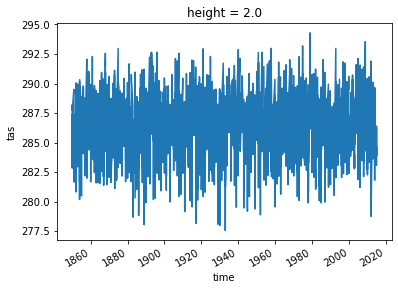

In [6]:
It2m.plot()

# IPSL wind speed and wind speed hilbert

In [7]:
# Read data
Iu10Data = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/uas_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
Iv10Data = xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/vas_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#Iu10Data=Iu10Data.assign_coords(time=("time", time1))
#Iv10Data=Iv10Data.assign_coords(time=("time", time1))

Iu10D = Iu10Data.sel(lat=slice(24,32),lon=slice(74,86))
Iv10D = Iv10Data.sel(lat=slice(24,32),lon=slice(74,86))
# Calculate wind speed
Iws = ((Iv10D.vas.values**2)+(Iu10D.uas.values**2))**0.5
Iws_ds = xr.Dataset({'Iws': (('time','lat','lon'), Iws)}, coords={'time': Iv10D.time,'lat': Iv10D.lat,'lon': Iv10D.lon})
#Mask
Iws_ds.Iws.values=Iws_ds.Iws.values*Imask
# area avg
IwsTS=Iws_ds.mean(dim=['lat','lon'], skipna=True).Iws
# hilbert
Iws_hb = np.imag(hilbert(IwsTS.values,axis=0))
Iws_hb_ds = xr.Dataset({'Iws_hb': (('time'), Iws_hb)}, coords={'time': IwsTS.time})
#Select Dec and Jan
Iws=IwsTS[((IwsTS.time.dt.month>11) | (IwsTS.time.dt.month<2))] 
Iwshb=Iws_hb_ds.Iws_hb[((Iws_hb_ds.time.dt.month>11) | (Iws_hb_ds.time.dt.month<2))]

# IPSL rh and rh hilbert

In [8]:
#Read Data
I_rhData= xr.open_mfdataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/hurs_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_rhData=I_rhData.assign_coords(time=("time", time1))

IrhD = I_rhData.sel(lat=slice(24,32),lon=slice(74,86))
IrhD.hurs.values=IrhD.hurs.values/100.0
#Mask data
IrhD.hurs.values=IrhD.hurs.values*Imask
# area avg
IrhTS=IrhD.mean(dim=['lat','lon'], skipna=True).hurs
#Hilbert transform
Irh_hb = np.imag(hilbert(IrhTS.values,axis=0))
Irh_hb_ds = xr.Dataset({'Irh_hb': (('time'), Irh_hb)}, coords={'time': IrhTS.time})
#ISelect only Dec Jan months
Irh=IrhTS[((IrhTS.time.dt.month>11) | (IrhTS.time.dt.month<2))]
Irhhb=Irh_hb_ds.Irh_hb[((Irh_hb_ds.time.dt.month>11) | (Irh_hb_ds.time.dt.month<2))] 


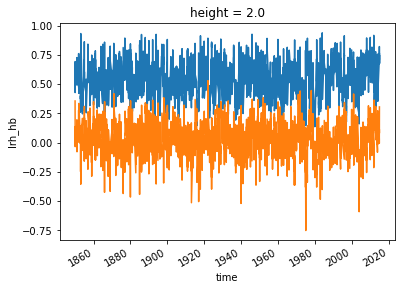

In [9]:
Irh.plot()
Irhhb.plot()

#  IPSL inv and inv hilbert

In [11]:
# Read 850 hPa t
I_tLevData= xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/ta_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_tLevData=I_tLevData.assign_coords(time=("time", time1))

It850D=I_tLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
It850D.ta.values=It850D.ta.values*Imask
# Calculate inv
Iinv = It2mD.tas.values-It850D.ta.values
Iinv_ds = xr.Dataset({'Iinv': (('time','lat','lon'), Iinv)}, coords={'time': It2mD.time,'lat': It2mD.lat,'lon': It2mD.lon})
#Iinv_ds.Iinv
#Mask
Iinv_ds.Iinv.values=Iinv_ds.Iinv.values*Imask
# area avg
IinvTS=Iinv_ds.mean(dim=['lat','lon'], skipna=True).Iinv
# hilbert
Iinv_hb = np.imag(hilbert(IinvTS.values,axis=0))
Iinv_hb_ds = xr.Dataset({'Iinv_hb': (('time'), Iinv_hb)}, coords={'time': IinvTS.time})
#Select Dec and Jan
Iinv=IinvTS[((IinvTS.time.dt.month>11) | (IinvTS.time.dt.month<2))] 
Iinvhb=Iinv_hb_ds.Iinv_hb[((Iinv_hb_ds.time.dt.month>11) | (Iinv_hb_ds.time.dt.month<2))]



In [12]:
I_tLevData

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, plev: 8, time: 19840)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    ta         (time, plev, lat, lon) float32 ...
Attributes:
    CDI:                    Climate Data Interface version 1.9.5 (http://mpim...
    history:                Tue Jan 26 13:02:34 2021: cdo selmon,1,2,11,12 ta...
    source:                 AWI-ESM 1.1 LR (2018): \naerosol: none\natmos: EC...
    institution:            Alfred Wegener Institute, Helmholtz Centre for Po...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  96057.0
    creation_date:          2020-04-01T06:39:09Z
    data_specs_version:     01.00.30
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              day
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.AWI.AWI-ESM-...
    grid:                   All grid attributes are set for the native grid a...
    grid_label:             gn
    initialization_index:   1
    institution_id:         AWI
    mip_era:                CMIP6
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       AWI-ESM-1-1-LR
    parent_time_units:      days since 1692-01-01 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source_id:              AWI-ESM-1-1-LR
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               day
    table_info:             Creation Date:(09 May 2019) MD5:dff4d5e7b28567869...
    title:                  AWI-ESM-1-1-LR output prepared for CMIP6
    variable_id:            ta
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by Alfred Wegener Insti...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/c935ef47-1d11-42f9-9587-cbda062f2c47
    CDO:                    Climate Data Operators version 1.9.5 (http://mpim...


# IPSL w700 and w700 hilbert

In [13]:
# Read Data
I_w700Data= xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/wap_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_w700Data=I_w700Data.assign_coords(time=("time", time1))

Iw700D = I_w700Data.sel(lat=slice(24,32),lon=slice(74,86),plev=(70000))
#Mask data
Iw700D.wap.values=Iw700D.wap.values*Imask
# area avg
Iw700TS=Iw700D.mean(dim=['lat','lon'], skipna=True).wap
#Hilbert transform
Iw700_hb = np.imag(hilbert(Iw700TS.values,axis=0))
Iw700_hb_ds = xr.Dataset({'Iw700_hb': (('time'), Iw700_hb)}, coords={'time': Iw700TS.time})
#ISelect only Dec Jan months
Iw700=Iw700TS[((Iw700TS.time.dt.month>11) | (Iw700TS.time.dt.month<2))]
Iw700hb=Iw700_hb_ds.Iw700_hb[((Iw700_hb_ds.time.dt.month>11) | (Iw700_hb_ds.time.dt.month<2))] 

# GFDL ushear and ushear hilbert

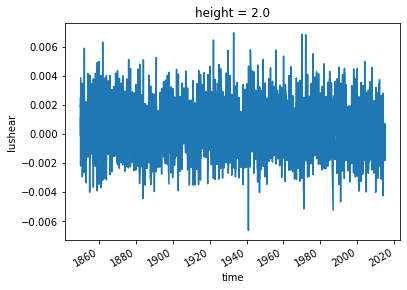

In [14]:
# Read 850 hPa u 
I_uLevData= xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/ua_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_uLevData=I_uLevData.assign_coords(time=("time", time1))

Iu850D=I_uLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Read 850 hPa  z 
I_zLevData= xr.open_dataset('../../../Data/CMIP6/AWI-ESM-1-1-LR/NDJF/zg_NDJFday_AWI-ESM-1-1-LR_historical_r1i1p1f1_gn_18500101-20141231.nc')
#I_zLevData=I_zLevData.assign_coords(time=("time", time1))

Iz850D=I_zLevData.sel(lat=slice(24,32),lon=slice(74,86),plev=85000)
# Calculate ushear
Iushear = (Iu850D.ua.values-Iu10D.uas.values)/(Iz850D.zg.values) 
Iushear_ds = xr.Dataset({'Iushear': (('time','lat','lon'), Iushear)}, coords={'time': It2mD.time,'lat': It2mD.lat,'lon': It2mD.lon})
#Iushear_ds.Iushear[0,:,:].plot()
#Mask
Iushear_ds.Iushear.values=Iushear_ds.Iushear.values*Imask
# area avg
IushearTS=Iushear_ds.mean(dim=['lat','lon'], skipna=True).Iushear
# hilbert
Iushear_hb = np.imag(hilbert(IushearTS.values,axis=0))
Iushear_hb_ds = xr.Dataset({'Iushear_hb': (('time'), Iushear_hb)}, coords={'time': IushearTS.time})
#Select Dec and Jan
Iushear=IushearTS[((IushearTS.time.dt.month>11) | (IushearTS.time.dt.month<2))] 
Iushearhb=Iushear_hb_ds.Iushear_hb[((Iushear_hb_ds.time.dt.month>11) | (Iushear_hb_ds.time.dt.month<2))]
Iushear.plot()

In [15]:
#IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0,
#                       It2mhb.values,Iwshb.values,Irhhb.values,Iinvhb.values,Iw700hb.values,Iushearhb.values]).T[:]
IX       = pd.DataFrame([It2m.values,Iws.values,Irh.values,Iinv.values,Iw700.values,Iushear.values*100.0]).T[:]



IX.index = pd.to_datetime(It2m.indexes['time'].values)
IX

,0,1,2,3,4,5
1850-01-01 12:00:00,287.083282,1.971405,0.645328,-1.289930,-0.038161,0.113998
1850-01-02 12:00:00,287.417969,2.436091,0.614763,4.662162,-0.136408,0.108481
1850-01-03 12:00:00,285.850250,2.728717,0.547644,5.355068,0.200286,-0.009434
1850-01-04 12:00:00,285.190521,2.536616,0.530502,2.071533,0.166928,0.057210
1850-01-05 12:00:00,284.950745,2.470063,0.494333,1.347307,0.164141,0.200860
...,...,...,...,...,...,...
2014-12-27 12:00:00,285.039825,1.883543,0.748159,1.783321,0.153494,0.050181
2014-12-28 12:00:00,284.064911,2.463040,0.674496,-1.302342,0.160916,-0.133574
2014-12-29 12:00:00,283.865509,1.247906,0.680633,-2.120623,0.052794,-0.182008
2014-12-30 12:00:00,284.190948,1.584967,0.722495,-1.712254,0.049508,-0.080903


In [16]:
normI = StandardScaler().fit(IX)
    # transform training data
IX = normI.transform(IX)
IX

array([[ 0.29805782,  0.0961815 ,  0.7285771 , -2.04911927, -0.40903235,
         0.54825853],
       [ 0.44242597,  0.88785561,  0.51971296,  0.26609776, -1.21096057,
         0.50969745],
       [-0.23381514,  1.38639554,  0.06105947,  0.53562108,  1.53725236,
        -0.31458697],
       ...,
       [-1.08994052, -1.13642617,  0.96983789, -2.37223828,  0.33337723,
        -1.52095744],
       [-0.94956102, -0.5621842 ,  1.25589656, -2.21339292,  0.30654971,
        -0.81418521],
       [-0.77017698, -0.41873632,  1.5100616 , -1.95658295, -0.62561248,
        -1.08235653]])

In [43]:
reg = load('regGB_Obs.joblib') 
reg

GradientBoostingRegressor(learning_rate=0.04, min_samples_leaf=20,
                          n_estimators=300, random_state=0)

In [44]:
regLin=load('regLR_Obs.joblib')
regLin

LinearRegression()

In [45]:
y_ds=load('y_ds_Obs.joblib')
y_ds

<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
    expver   float64 1.0
  * time     (time) datetime64[ns] 1980-01-01T10:30:00 ... 2014-12-31T10:30:00
Data variables:
    y        (time) float64 0.32 0.4 0.4 0.36 0.32 ... 0.68 0.8 0.76 0.72 0.76

In [46]:
y_pred_ds=load('y_pred_ds_Obs.joblib')
y_pred_ds

<xarray.Dataset>
Dimensions:  (time: 2170)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    y_pred   (time) float64 0.2012 0.2858 0.3558 0.3774 ... 0.6405 0.6206 0.6037

In [47]:
y_predLin_ds=load('y_predLin_ds_Obs.joblib')
y_predLin_ds

<xarray.Dataset>
Dimensions:    (time: 2170)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Data variables:
    y_predLin  (time) float64 0.2822 0.383 0.3899 ... 0.5674 0.5565 0.4545

In [48]:
Iy_pred=reg.predict(IX)
Iy_predLin=regLin.predict(IX)
Iy_df = pd.DataFrame(Iy_pred)
Iy_df.index = pd.to_datetime(It2m.indexes['time'].values)
Iy_dfLin = pd.DataFrame(Iy_predLin)
Iy_dfLin.index = pd.to_datetime(It2m.indexes['time'].values)

In [49]:
Iy_ds=xr.Dataset({'Iy_pred': (('time'), Iy_pred)}, coords={'time': It2m.time})
Iy_ds

IyLin_ds=xr.Dataset({'Iy_predLin': (('time'), Iy_predLin)}, coords={'time': It2m.time})
IyLin_ds

<xarray.Dataset>
Dimensions:     (time: 10230)
Coordinates:
    height      float64 2.0
  * time        (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:0...
Data variables:
    Iy_predLin  (time) float64 0.4592 0.255 0.2709 ... 0.5844 0.5992 0.5687

(0.816141217070912, 0.0)

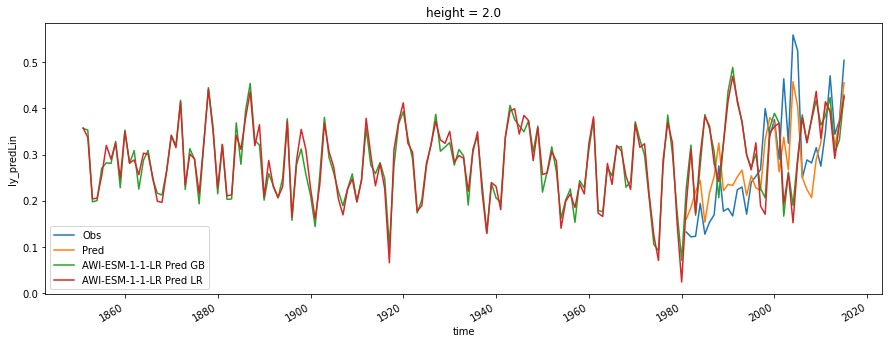

In [50]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')


Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='AWI-ESM-1-1-LR Pred GB')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time').plot(label='AWI-ESM-1-1-LR Pred LR')

plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)
#y_ds.y.values.corr(y_pred_ds.y_pred.values)

(0.816141217070912, 0.0)

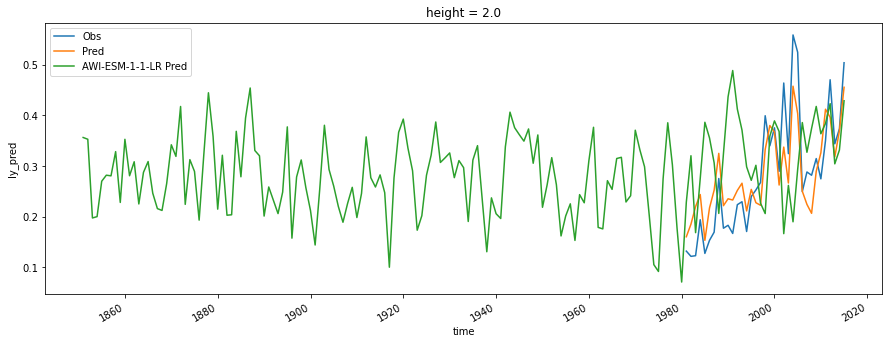

In [51]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time').plot(label='AWI-ESM-1-1-LR Pred')


plt.legend()
np.corrcoef(y_ds.y.values, y_pred_ds.y_pred.values)
stats.pearsonr(y_ds.y.values, y_pred_ds.y_pred.values)

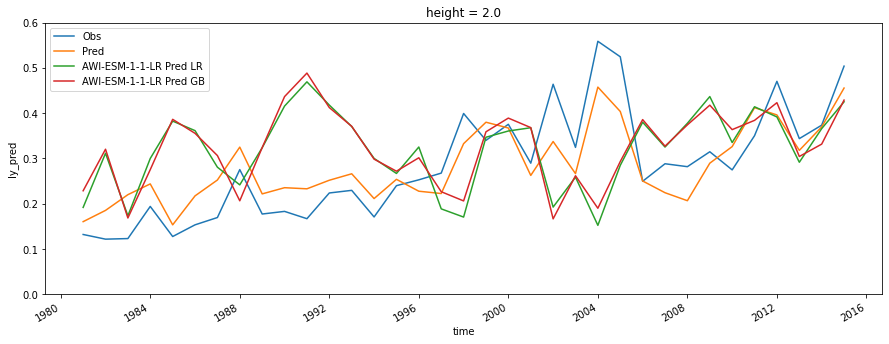

In [52]:
plt.figure(figsize=[15,5])
y_ds.resample(time='1Y').mean().y.dropna(dim='time').plot(label='Obs')
y_pred_ds.resample(time='1Y').mean().y_pred.dropna(dim='time').plot(label='Pred')
IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[130:].plot(label='AWI-ESM-1-1-LR Pred LR')
Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[130:].plot(label='AWI-ESM-1-1-LR Pred GB')
plt.ylim(0, 0.6)
plt.legend()
plt.savefig('../AWI-ESM-1-1-LR_yearly.jpeg',dpi=300)

In [54]:
Widespread_Iy_pred=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).count())
# mean annual frequency
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(Iy_ds.Iy_pred.sel(time=slice('1980-1-1','2014-12-31')).where(Iy_ds.Iy_pred > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_pred' ()>
array(548)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_pred' ()>
array(15.65714286)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_pred' ()>
array(9.36541619)
Coordinates:
    height   float64 2.0


In [55]:
Widespread_Iy_predLin=IyLin_ds.Iy_predLin.where(IyLin_ds.Iy_predLin > 0.44, drop=True)
# Total number of widespread fog days
print(Widespread_Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).count())
# mean annual frequency
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().mean())
# interannual std 
print(IyLin_ds.Iy_predLin.sel(time=slice('1980-1-1','2014-12-31')).where(IyLin_ds.Iy_predLin > 0.44).resample(time='1Y').count().std())
#Widespread_y_pred.resample(time='1Y').count()

<xarray.DataArray 'Iy_predLin' ()>
array(524)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_predLin' ()>
array(14.97142857)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Iy_predLin' ()>
array(9.91243293)
Coordinates:
    height   float64 2.0


In [53]:
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,Iy_ds.resample(time='1Y').mean().Iy_pred[130:]))
print(np.corrcoef(y_ds.resample(time='1Y').mean().y,IyLin_ds.resample(time='1Y').mean().Iy_predLin[130:]))

[[ 1.         -0.09735495]
 [-0.09735495  1.        ]]
[[ 1.         -0.11248254]
 [-0.11248254  1.        ]]


obsTs=y_ds.resample(time='1M').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%m-%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1M').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%m-%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1M').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%m-%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

obsTs=y_ds.resample(time='1Y').mean().y.dropna(dim='time')
time1=obsTs["time"].dt.strftime("%Y")
obsTs1=obsTs.assign_coords(time=("time", time1))


GBTs=Iy_ds.resample(time='1Y').mean().Iy_pred.dropna(dim='time')[259:]
timeGB=GBTs["time"].dt.strftime("%Y")
GBTs1=GBTs.assign_coords(time=("time", timeGB))
GBTs1

LinTs=IyLin_ds.resample(time='1Y').mean().Iy_predLin.dropna(dim='time')[259:]
timeLin=LinTs["time"].dt.strftime("%Y")
LinTs1=LinTs.assign_coords(time=("time", timeGB))
LinTs1



plt.figure(figsize=[15,5])
plt.plot(obsTs1.time.values,obsTs1.values,label='Obs')
plt.plot(GBTs1.time.values,GBTs1.values,label='GB_GFDL')
plt.plot(LinTs1.time.values,LinTs1.values,label='LR_GFDL')
plt.xticks(rotation=90)
plt.legend() 
#y_ds1.y.plot()

In [56]:
# Read z500 data
Iz500Data_Orig = I_zLevData.sel(plev=50000)
#Iz500Data


# Calculate anomalies

In [57]:
climatology = Iz500Data_Orig.groupby("time.dayofyear").mean("time")
Iz500Data = Iz500Data_Orig.groupby("time.dayofyear") - climatology
#climatology
Iz500Data.time

<xarray.DataArray 'time' (time: 19840)>
array(['1850-01-01T12:00:00.000000000', '1850-01-02T12:00:00.000000000',
       '1850-01-03T12:00:00.000000000', ..., '2014-12-29T12:00:00.000000000',
       '2014-12-30T12:00:00.000000000', '2014-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
    plev       float64 5e+04
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [58]:
Iy_ds.Iy_pred
Widespread_Iy1=Iy_ds.Iy_pred.where(Iy_ds.Iy_pred > 0.44, drop=True)
Widespread_Iy=Widespread_Iy1.sel(time=slice('1980-1-1','2014-12-31'))
totalCnt=Widespread_Iy.time.sizes
totalCnt

Frozen({'time': 548})

In [59]:
time1=Widespread_Iy.time
time1

<xarray.DataArray 'time' (time: 548)>
array(['1980-12-15T12:00:00.000000000', '1980-12-16T12:00:00.000000000',
       '1980-12-17T12:00:00.000000000', ..., '2014-12-29T12:00:00.000000000',
       '2014-12-30T12:00:00.000000000', '2014-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1980-12-15T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [32]:
zwide=Iz500Data.sel(time=Widespread_Iy.time,method="nearest")
zwide

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 664)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01T12:00:00 ... 2014-01-06T12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    plev       float64 5e+04
    dayofyear  (time) int64 336 337 338 350 351 352 353 ... 362 363 364 365 5 6
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (time, lon, bnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lat_bnds   (time, lat, bnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    zg         (time, lat, lon) float32 -63.49 -63.62 -63.75 ... 25.82 26.29

In [33]:
zwidePos=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes

In [34]:
zwideNeg=zwide.zg.where(zwide.zg.sel(lat=slice(20,40),lon=slice(60,85)).mean(dim=['lat','lon']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes

In [35]:
zwideAll=zwide.zg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zwideAll

In [36]:
zNeg=zwideNeg.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zNeg

zPos=zwidePos.sel(lat=slice(0,70),lon=slice(20,150)).mean(dim='time')
#zPos

In [37]:
zwideNeg

<xarray.DataArray 'zg' (time: 173, lat: 96, lon: 192)>
array([[[ -93.13965  ,  -92.74121  ,  -92.37988  , ...,  -94.354004 ,
          -93.9209   ,  -93.52734  ],
        [ -86.80371  ,  -85.759766 ,  -84.74512  , ...,  -90.13379  ,
          -89.03662  ,  -87.88037  ],
        [ -77.91699  ,  -76.94385  ,  -76.015625 , ...,  -81.274414 ,
          -80.114746 ,  -78.98389  ],
        ...,
        [ 135.76074  ,  135.58643  ,  135.42676  , ...,  136.46582  ,
          136.18945  ,  135.97461  ],
        [ 141.28223  ,  140.78711  ,  140.3164   , ...,  142.78223  ,
          142.26318  ,  141.75977  ],
        [ 140.49219  ,  140.19043  ,  139.88477  , ...,  141.33008  ,
          141.0586   ,  140.78809  ]],

       [[ -93.04297  ,  -92.970215 ,  -92.93945  , ...,  -93.39502  ,
          -93.26367  ,  -93.13672  ],
        [ -69.848145 ,  -69.41846  ,  -69.049805 , ...,  -71.38623  ,
          -70.941895 ,  -70.36963  ],
        [ -47.046875 ,  -46.645508 ,  -46.35205  , ...,  -49.106934 ,
          -48.320312 ,  -47.635742 ],
...
        [-268.11133  , -267.90918  , -267.70947  , ..., -268.64697  ,
         -268.4712   , -268.2832   ],
        [-293.7544   , -293.3296   , -292.88184  , ..., -295.14453  ,
         -294.6626   , -294.2163   ],
        [-308.5298   , -308.1045   , -307.68604  , ..., -309.79346  ,
         -309.36084  , -308.93213  ]],

       [[ -60.617676 ,  -60.168945 ,  -59.697754 , ...,  -61.950684 ,
          -61.520508 ,  -61.066895 ],
        [ -62.504883 ,  -61.790527 ,  -60.958984 , ...,  -64.35596  ,
          -63.802246 ,  -63.195312 ],
        [ -55.62744  ,  -54.43799  ,  -53.023438 , ...,  -57.976074 ,
          -57.410645 ,  -56.617188 ],
        ...,
        [  17.939941 ,   20.993164 ,   24.161621 , ...,    9.664551 ,
           12.259766 ,   15.026367 ],
        [  17.88623  ,   20.052734 ,   22.303223 , ...,   11.85498  ,
           13.770508 ,   15.802246 ],
        [  27.818848 ,   28.796387 ,   29.838379 , ...,   24.934082 ,
           25.84961  ,   26.833496 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-02T12:00:00 ... 2014-01-05T12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    plev       float64 5e+04
    dayofyear  (time) int64 337 338 350 351 352 353 ... 345 353 363 364 365 5
    height     float64 2.0

In [38]:
zwidePos

<xarray.DataArray 'zg' (time: 491, lat: 96, lon: 192)>
array([[[-6.3487793e+01, -6.3615723e+01, -6.3752930e+01, ...,
         -6.3189941e+01, -6.3249023e+01, -6.3346680e+01],
        [-5.4828125e+01, -5.5072754e+01, -5.5116211e+01, ...,
         -5.4363281e+01, -5.4480957e+01, -5.4628906e+01],
        [-5.3772461e+01, -5.3783203e+01, -5.3899902e+01, ...,
         -5.4288574e+01, -5.4040527e+01, -5.3845215e+01],
        ...,
        [ 1.6411914e+02,  1.6337402e+02,  1.6264648e+02, ...,
          1.6641357e+02,  1.6564404e+02,  1.6487891e+02],
        [ 1.6311963e+02,  1.6286475e+02,  1.6259961e+02, ...,
          1.6383936e+02,  1.6360547e+02,  1.6336865e+02],
        [ 1.5528516e+02,  1.5518945e+02,  1.5506055e+02, ...,
          1.5562646e+02,  1.5553027e+02,  1.5540430e+02]],

       [[-1.8474121e+01, -1.8935059e+01, -1.9377930e+01, ...,
         -1.7203125e+01, -1.7597168e+01, -1.8029297e+01],
        [-1.4041016e+01, -1.5176270e+01, -1.6343262e+01, ...,
         -1.1005859e+01, -1.1939941e+01, -1.2972168e+01],
        [-2.3867188e+00, -3.4165039e+00, -4.6054688e+00, ...,
         -2.5390625e-02, -6.9238281e-01, -1.4707031e+00],
...
        [-1.8409424e+02, -1.8333301e+02, -1.8250732e+02, ...,
         -1.8571387e+02, -1.8526074e+02, -1.8473047e+02],
        [-2.0342188e+02, -2.0319531e+02, -2.0293896e+02, ...,
         -2.0389551e+02, -2.0375879e+02, -2.0361914e+02],
        [-2.2227441e+02, -2.2215674e+02, -2.2207178e+02, ...,
         -2.2268018e+02, -2.2250830e+02, -2.2239600e+02]],

       [[-4.7398438e+01, -4.7467773e+01, -4.7545898e+01, ...,
         -4.7109863e+01, -4.7226562e+01, -4.7324219e+01],
        [-4.6691406e+01, -4.7087402e+01, -4.7406738e+01, ...,
         -4.5301270e+01, -4.5840820e+01, -4.6273926e+01],
        [-3.4287598e+01, -3.4728027e+01, -3.5006348e+01, ...,
         -3.2099609e+01, -3.2969727e+01, -3.3673828e+01],
        ...,
        [ 5.0651367e+01,  5.1763184e+01,  5.2811523e+01, ...,
          4.7155762e+01,  4.8346680e+01,  4.9508301e+01],
        [ 4.2642578e+01,  4.3403320e+01,  4.4117676e+01, ...,
          4.0087891e+01,  4.0986816e+01,  4.1839844e+01],
        [ 2.6730957e+01,  2.7132812e+01,  2.7530273e+01, ...,
          2.5320312e+01,  2.5820801e+01,  2.6288574e+01]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1980-12-01T12:00:00 ... 2014-01-06T12:00:00
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
    plev       float64 5e+04
    dayofyear  (time) int64 336 356 357 358 366 1 2 ... 349 350 352 361 362 6
    height     float64 2.0

In [39]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([20,40 , 60,80, 100,120, 140], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 10, 20, 30, 40, 50, 60,70], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

In [40]:
# for contour labels
delta = 5.0
x = np.arange(-60, 60, delta)
y = np.arange(-60, 60, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'


class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.pcolor(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
ax1.set_title('AWI-ESM-1-1-LR Neg Widespread Fog Days')
fig.colorbar(m1,orientation='horizontal')

ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())

m2=ax2.pcolor(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),cmap='jet',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax2)
ax2.coastlines()
ax2.set_title('AWI-ESM-1-1-LR Pos Widespread Fog Days')

fig.colorbar(m2,orientation='horizontal')

plt.savefig('../AWI-ESM-1-1-LRWDF_pos_Neg.jpeg',dpi=300)


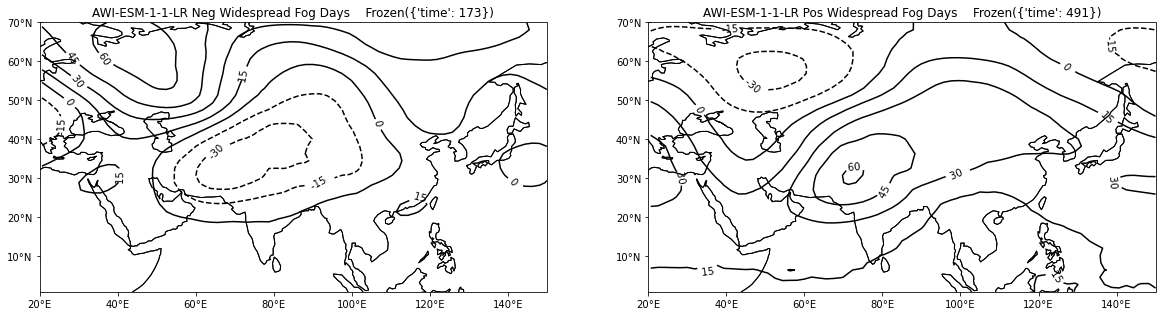

In [41]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zNeg.lon.values,zNeg.lat.values,zNeg,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title('AWI-ESM-1-1-LR Neg Widespread Fog Days'+"    "+str(NegCnt))
#fig.colorbar(m1,orientation='horizontal')


########## second Figure
ax2 = fig.add_subplot(122,projection=ccrs.PlateCarree())
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
m2=ax2.contour(zPos.lon.values,zPos.lat.values,zPos,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
map_plot(ax2)
ax2.coastlines()

# Recast levels to new class
m2.levels = [nf(val) for val in m2.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax2.clabel(m2, m2.levels, inline=True, fmt=fmt, fontsize=10)

ax2.set_title('AWI-ESM-1-1-LR Pos Widespread Fog Days'+"    "+str(PosCnt))

#fig.colorbar(m2,orientation='horizontal')

plt.savefig('../AWI-ESM-1-1-LRWDF_pos_Neg.jpeg',dpi=300)


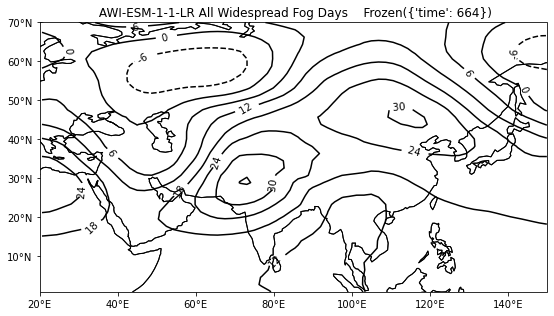

In [42]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())

m1=ax1.contour(zwideAll.lon.values,zwideAll.lat.values,zwideAll,transform=ccrs.PlateCarree(),colors ='black',vmax=60,vmin=-60)
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
# Recast levels to new class
m1.levels = [nf(val) for val in m1.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax1.clabel(m1, m1.levels, inline=True, fmt=fmt, fontsize=10)
ax1.set_title(' AWI-ESM-1-1-LR All Widespread Fog Days'+"    "+str(totalCnt) )
#fig.colorbar(m1,orientation='horizontal')
plt.savefig('../AWI-ESM-1-1-LRWDF_All.jpeg',dpi=300)